# Plots for Dussin et al., Hypoxia Drivers

## Import python modules and define functions

In [1]:
# We need to manually set the path for PROJ_LIB
# you may need to change this according to your environment
import os
# RD laptop
os.environ['PROJ_LIB'] = '/opt/anaconda2/5.1.0/envs/pubs/share/proj/'
# binder
#os.environ['PROJ_LIB'] =

In [2]:
# all these packages are standard python modules
import netCDF4 as nc
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as cl
import matplotlib.ticker as ticker
from mpl_toolkits.basemap import Basemap
from scipy import ndimage as im
from scipy import spatial
import seaborn as sns
import pandas as pd
from terminaltables import AsciiTable

In [3]:
# check python version, needs to be 2.7
import sys
sys.version

'2.7.15 | packaged by conda-forge | (default, Nov 28 2018, 14:50:16) \n[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.38)]'

In [4]:
from Dussin_et_al_Hypoxia_Drivers_utils import *

## Data

All data is included in the subdirectory

In [5]:
datadir = './data_Dussin_Hypoxia_drivers/'

# Figure 2: Comparison of hypoxic boundary in REF and WOA13

In [6]:
def make_plot_hypoxic_bdry_map(datadir):
    ''' make validation plot on hypoxic boundary '''
    # get colormap from file
    rt_colormaps = rt_getcolormaps()
    pal = rt_colormaps['pastel1']
    # colorbar options
    cbarfmt = "%01g"
    norm = cl.Normalize(vmin=-600, vmax=0)
    contours=np.arange(-600.,-90.+10.,10.)
    ticks=np.arange(-600,-100+100,100)
    # layout options
    sns.set(font_scale=1.4)
    sns.set_style("darkgrid", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"],
    'grid.linestyle': '-'
    })

    # read data
    file_REF = 'CCS1-RD.NVOcobalt31S_hypoxic_bdry_annual_1996-2006.nc'
    file_WOA = 'WOA13_hypoxic_bdry_annual_clim.nc'
    lon = readnc(datadir + file_REF, 'lon') 
    lat = readnc(datadir + file_REF, 'lat')
    hyp_bd_REF = readnc(datadir + file_REF, 'hypoxic_boundary')
    hyp_bd_WOA = readnc(datadir + file_WOA, 'hypoxic_boundary')
    # mask special values
    hyp_bd_REF = np.ma.masked_values(hyp_bd_REF,-9999.)
    hyp_bd_WOA = np.ma.masked_values(hyp_bd_WOA,-9999.)
    
    # start figure
    fig = plt.figure(figsize=[24.,12.])
    # model
    ax  = fig.add_subplot(121)
    m = setup_map_small(datadir, hide_grid=True)
    C = m.contourf(lon, lat, hyp_bd_REF, contours, cmap=pal, norm=norm)
    cbar = plt.colorbar(C, format=cbarfmt, shrink=0.7, ticks=ticks)
    cbar.ax.set_yticklabels(ticks, fontsize=20)
    # add central CCS band
    m.plot(lon[220,:135],lat[220,:135],'k--')
    m.plot(lon[380,:155],lat[380,:155],'k--')

    # WOA
    ax  = fig.add_subplot(122)
    m = setup_map_small(datadir, hide_grid=True)
    C = m.contourf(lon, lat, hyp_bd_WOA, contours, cmap=pal, norm=norm)
    cbar = plt.colorbar(C, format=cbarfmt, shrink=0.7, ticks=ticks)
    cbar.ax.set_yticklabels(ticks, fontsize=20)
    # add central CCS bands
    m.plot(lon[220,:135],lat[220,:135],'k--')
    m.plot(lon[380,:155],lat[380,:155],'k--')

    #plt.savefig(plotsdir + '/validation_hypoxic_bdry_REF.png',bbox_inches='tight')

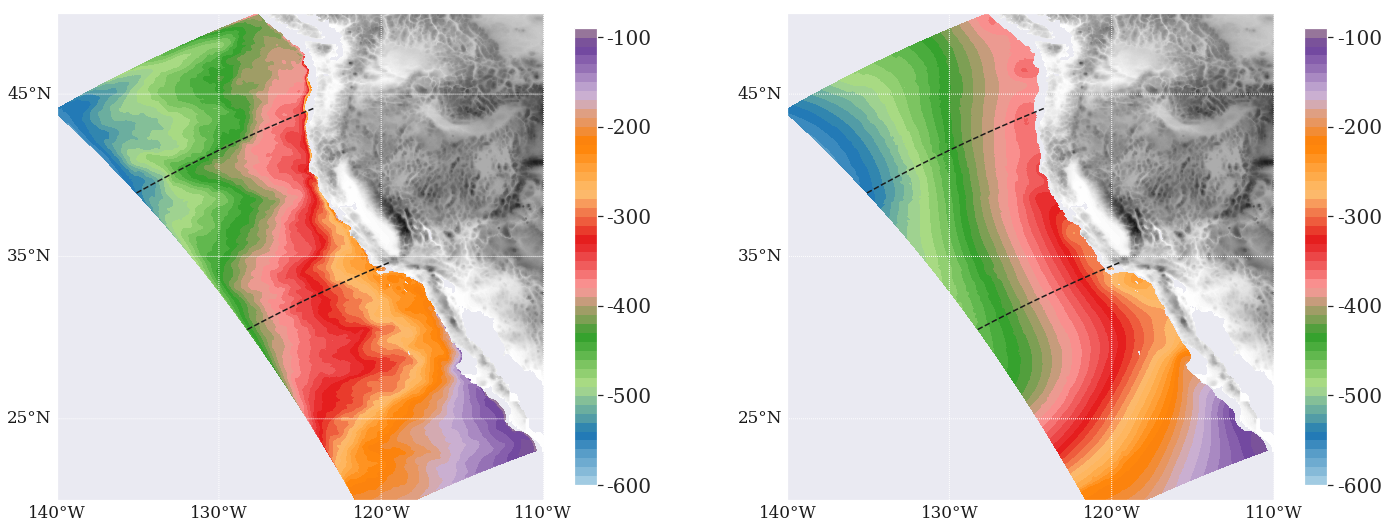

In [7]:
make_plot_hypoxic_bdry_map(datadir)